# Example Site Study
Look at ways to unpack data from a specific site and apply simulated change estimates.

Will use monthyl mean wind speed and only a pair of simulations, but can easily extend things on the server once we feel that we have some good sample figures.

_Worth noting, I worry that all of this is of suspect value compared to more conceptual synoptic analysis._

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr

from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KernelDensity
from scipy.interpolate import CubicSpline

register_matplotlib_converters()
cmap = sns.color_palette('Set2')
sns.set_style('darkgrid')
sns.set_palette('Set2')

%matplotlib inline

##### Site series
Identify the document and table that will consider in this example.

In [2]:
site_lat = 53.5
site_lon = 0

In [3]:
fname_site = '../data/UKsite/Donna_nook_and_other.xlsx'
lab_windspeed = "Wind Speed scaled Donna Nook [m/s]"

In [4]:
D = pd.read_excel(fname_site,sheet_name='Donna Nook')
D.index = pd.to_datetime(D['Date/Time'].values)

##### Sim series
Identify some simulation files to use in the example. 

In [5]:
fname_hsims = [
    (('../data/NorthSea_uas_EUR-11_NCC-NorESM1-M'
      + '_historical_r1i1p1_DMI-HIRHAM5_v2_day.nc'),
     ('../data/NorthSea_vas_EUR-11_NCC-NorESM1-M'
      + '_historical_r1i1p1_DMI-HIRHAM5_v2_day.nc')),
    (('../data/NorthSea_uas_EUR-11_MPI-M-MPI-ESM-LR'
      +'_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_day.nc'),
     ('../data/NorthSea_vas_EUR-11_MPI-M-MPI-ESM-LR'
      +'_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_day.nc'))]

In [6]:
fname_psims = [
    (('../data/NorthSea_uas_EUR-11_NCC-NorESM1-M'
      + '_rcp85_r1i1p1_DMI-HIRHAM5_v2_day.nc'),
     ('../data/NorthSea_vas_EUR-11_NCC-NorESM1-M'
      + '_rcp85_r1i1p1_DMI-HIRHAM5_v2_day.nc')),
    (('../data/NorthSea_uas_EUR-11_MPI-M-MPI-ESM-LR'
      +'_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day.nc'),
     ('../data/NorthSea_vas_EUR-11_MPI-M-MPI-ESM-LR'
      +'_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day.nc'))]

_The below is sloppy and should be condensed into a function to be called repeatedly for different simulation files._

In [7]:
for ix_sim in range(len(fname_hsims)) :
    
    sim_lab = 'Sim'+str(ix_sim).zfill(2)

    ## Historical
    X = xr.open_dataset(fname_hsims[ix_sim][0])
    dist_matr = np.sqrt(
        ((X.lat.values-site_lat)**2)
        + ((X.lon.values-site_lon)**2))
    x = pd.DataFrame(
        X.uas.values[:,(dist_matr == dist_matr.min())],
        index=pd.to_datetime(X.time.values),
        columns=['uas'])

    X = xr.open_dataset(fname_hsims[0][1])
    dist_matr = np.sqrt(
        ((X.lat.values-site_lat)**2)
        + ((X.lon.values-site_lon)**2))
    x = pd.merge(
        left=x,
        right= pd.DataFrame(
            X.vas.values[:,(dist_matr == dist_matr.min())],
            index=pd.to_datetime(X.time.values),
            columns=['vas']),
        left_index=True,
        right_index=True)

    ws_hist = pd.DataFrame(
        np.sqrt((x.uas.values**2)
                +(x.vas.values**2)),
        index=x.index,
        columns=[sim_lab])

    ## Projection
    X = xr.open_dataset(fname_psims[ix_sim][0])
    dist_matr = np.sqrt(
        ((X.lat.values-site_lat)**2)
        + ((X.lon.values-site_lon)**2))
    x = pd.DataFrame(
        X.uas.values[:,(dist_matr == dist_matr.min())],
        index=pd.to_datetime(X.time.values),
        columns=['uas'])

    X = xr.open_dataset(fname_psims[0][1])
    dist_matr = np.sqrt(
        ((X.lat.values-site_lat)**2)
        + ((X.lon.values-site_lon)**2))
    x = pd.merge(
        left=x,
        right= pd.DataFrame(
            X.vas.values[:,(dist_matr == dist_matr.min())],
            index=pd.to_datetime(X.time.values),
            columns=['vas']),
        left_index=True,
        right_index=True)

    ws_proj = pd.DataFrame(
        np.sqrt((x.uas.values**2)
                +(x.vas.values**2)),
        index=x.index,
        columns=[sim_lab])
    
    ws = pd.concat([ws_hist,ws_proj])
    
    if ix_sim == 0 : 
        S_ws = ws
    else : 
        S_ws = pd.merge(
            left=S_ws,right=ws,
            left_index=True,
            right_index=True)
        

## Comparison
Show what the different time series "look like". 

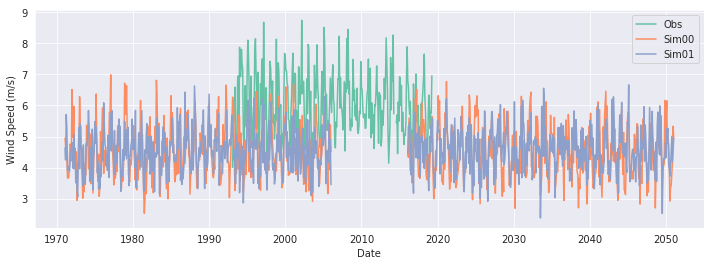

In [8]:
## Time Series
_ = plt.figure(figsize=(12,4))
_ = plt.plot(
    D[lab_windspeed
     ].resample('M').mean(),
    color=cmap[0],
    label='Obs'
)

c = 1
for sim_lab in S_ws.columns : 
    _ = plt.plot(
        S_ws[sim_lab
         ].resample('M').mean(),
        color=cmap[c],
        label=sim_lab
    )
    c += 1
    
_ = plt.ylabel('Wind Speed (m/s)')
_ = plt.xlabel('Date')
_ = plt.legend()

In [23]:
ix_hist = S_ws.index.year < 2010

/home/tristan/anaconda3/envs/gis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/tristan/anaconda3/envs/gis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


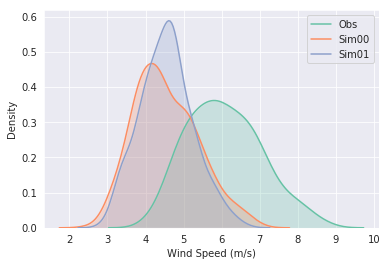

In [24]:
## Distribution
_ = sns.kdeplot(
    D[lab_windspeed].resample('M').mean().values,
    label='Obs',
    shade=True
)

c = 1
for sim_lab in S_ws.columns : 
    _ = sns.kdeplot(
        S_ws.loc[ix_hist,sim_lab].resample('M').mean().values,
        shade=True,
        color=cmap[c],
        label=sim_lab
    )
    c += 1
    
_ = plt.xlabel('Wind Speed (m/s)')
_ = plt.ylabel('Density')

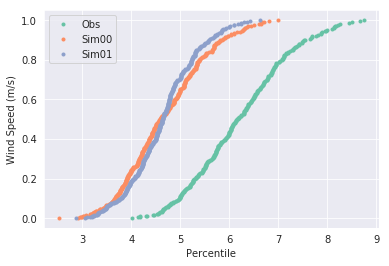

In [25]:
## Percentiles
X = D[lab_windspeed].resample('M').mean().dropna().values
_ = plt.plot(
    np.sort(X),
    (np.sort(X)/np.sum(X)).cumsum(),
    '.',
    linewidth=4,
    label='Obs'
)

c = 1
for sim_lab in S_ws.columns : 
    X = S_ws.loc[ix_hist,sim_lab].resample('M').mean().dropna().values
    _ = plt.plot(
        np.sort(X),
        (np.sort(X)/np.sum(X)).cumsum(),
        '.',
        linewidth=4,
        color=cmap[c],
        label=sim_lab
    )
    c += 1

_ = plt.ylabel('Wind Speed (m/s)')
_ = plt.xlabel('Percentile')
_ = plt.legend()

The simulation seems to consistantly underestimate the magnitude of the wind speeds.

## Bias correction
Just a quick check of what happesn if you just "nudge" everything to the right.

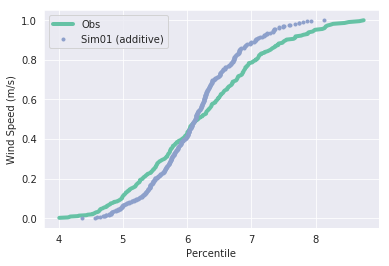

In [26]:
## Percentiles
X = D[lab_windspeed].resample('M').mean().dropna().values
_ = plt.plot(
    np.sort(X),
    (np.sort(X)/np.sum(X)).cumsum(),
    linewidth=4,
    label='Obs'
)

c = 2
for sim_lab in S_ws.columns[1:] : 
    X = S_ws.loc[ix_hist,sim_lab].resample('M').mean().dropna().values+1.5
    _ = plt.plot(
        np.sort(X),
        (np.sort(X)/np.sum(X)).cumsum(),
        '.',
        linewidth=2,
        color=cmap[c],
        label=sim_lab+' (additive)'
    )
    c += 1
    
_ = plt.ylabel('Wind Speed (m/s)')
_ = plt.xlabel('Percentile')
_ = plt.legend()

Can nudge the two series close, but still don't get the best match for range, or shape of the distribution. 

So instead will use quantile mapping by setting an the inverse transform to convert any value within the range of the original "B" data set to it's "A" equivilant, and then fitting a cubic spline interpolation to define the resulting curve over the full potential value range. 

_Should note, quantile mapping can be a very very bad idea in many cases. There are many issues, but most notable is that it caps the possible values within the range of the observed values. For a situation where we expect a shift in values to one end or the other of the current observed range (e.g., strong winds happening more often) then this is a functional bias correction. If we suspect the potential for changes that will change the range of possible values (e.g., tropical level rainfalls in regions that previously had different precipitation generating mechanisms) then this approach can be periously missleading._

In [78]:
Xs = S_ws.resample('M').mean().dropna()
Xr = S_ws.resample('M').mean().dropna()

In [79]:
ix_hist = (Xs.index.year < 2010)

for sim_lab in S_ws.columns : 
    
    ## Create distinct transform-objects for each data set
    Xd = D[lab_windspeed].resample('M').mean().dropna()
    #Xs = S_ws.loc[ix_hist,sim_lab].resample('M').mean().dropna()
    qt0 = QuantileTransformer(n_quantiles=100, random_state=0)
    _ = qt0.fit(Xd.values.reshape(-1, 1))
    qt1 = QuantileTransformer(n_quantiles=100, random_state=0)
    _ = qt1.fit(Xs.loc[ix_hist,sim_lab].values.reshape(-1,1))

    ## Evaluate quantile map function
    z = np.linspace(Xs.min().min()-5,Xs.max().max()+5,1000)
    z1 = qt1.transform(z.reshape(-1,1))
    zt = qt0.inverse_transform(z1)
    cs = CubicSpline(
        z,zt[:,0],extrapolate=False)
    
    Xr.loc[:,sim_lab] = cs(Xs.loc[:,sim_lab])
    

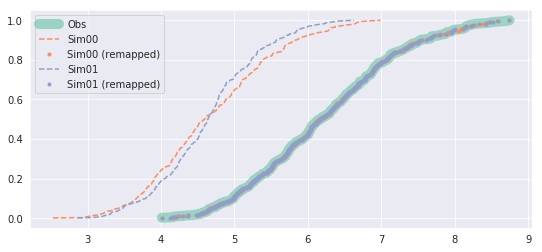

In [87]:
## Compare reults
_ = plt.figure(figsize=(9,4))
_ = plt.plot(
    np.sort(Xd),
    (np.sort(Xd)/np.sum(Xd)).cumsum(),
    linewidth=10,
    alpha=0.6,
    color=cmap[0],
    label='Obs'
)

c = 1
for sim_lab in S_ws.columns : 

    _ = plt.plot(
        np.sort(Xs.loc[ix_hist,sim_lab].values),
        (np.sort(Xs.loc[ix_hist,sim_lab].values)
         / np.nansum(Xs.loc[ix_hist,sim_lab].values)).cumsum(),
        '--',
        color=cmap[c],
        label=sim_lab
    )
    _ = plt.plot(
        np.sort(Xr.loc[ix_hist,sim_lab].values),
        (np.sort(Xr.loc[ix_hist,sim_lab])
         / np.nansum(Xr.loc[ix_hist,sim_lab].values)).cumsum(),
        '.',
        color=cmap[c],
        label=sim_lab+' (remapped)'
    )
    c += 1
    
_ = plt.legend()

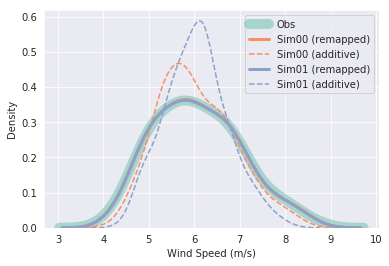

In [90]:
## Distribution
_ = sns.kdeplot(
    Xd.values,
    color=cmap[0],
    linewidth=10,
    alpha=0.5,
    shade=False,
    label='Obs'
)

c = 1
for sim_lab in Xr.columns : 
    
    _ = sns.kdeplot(
        Xr.loc[ix_hist,sim_lab].values,
        shade=False,
        color=cmap[c],
        linewidth=3,
        label=sim_lab+' (remapped)'
    )
    _ = sns.kdeplot(
        Xs.loc[ix_hist,sim_lab]+1.5,
        linestyle='--',
        shade=False,
        color=cmap[c],
        label=sim_lab+' (additive)'
    )
    c += 1
    
_ = plt.xlabel('Wind Speed (m/s)')
_ = plt.ylabel('Density')

So can see that the quantile mapping reshapes the historical simulated distribution to match the observed in a way that adding linear bias terms do not. 

## Projections

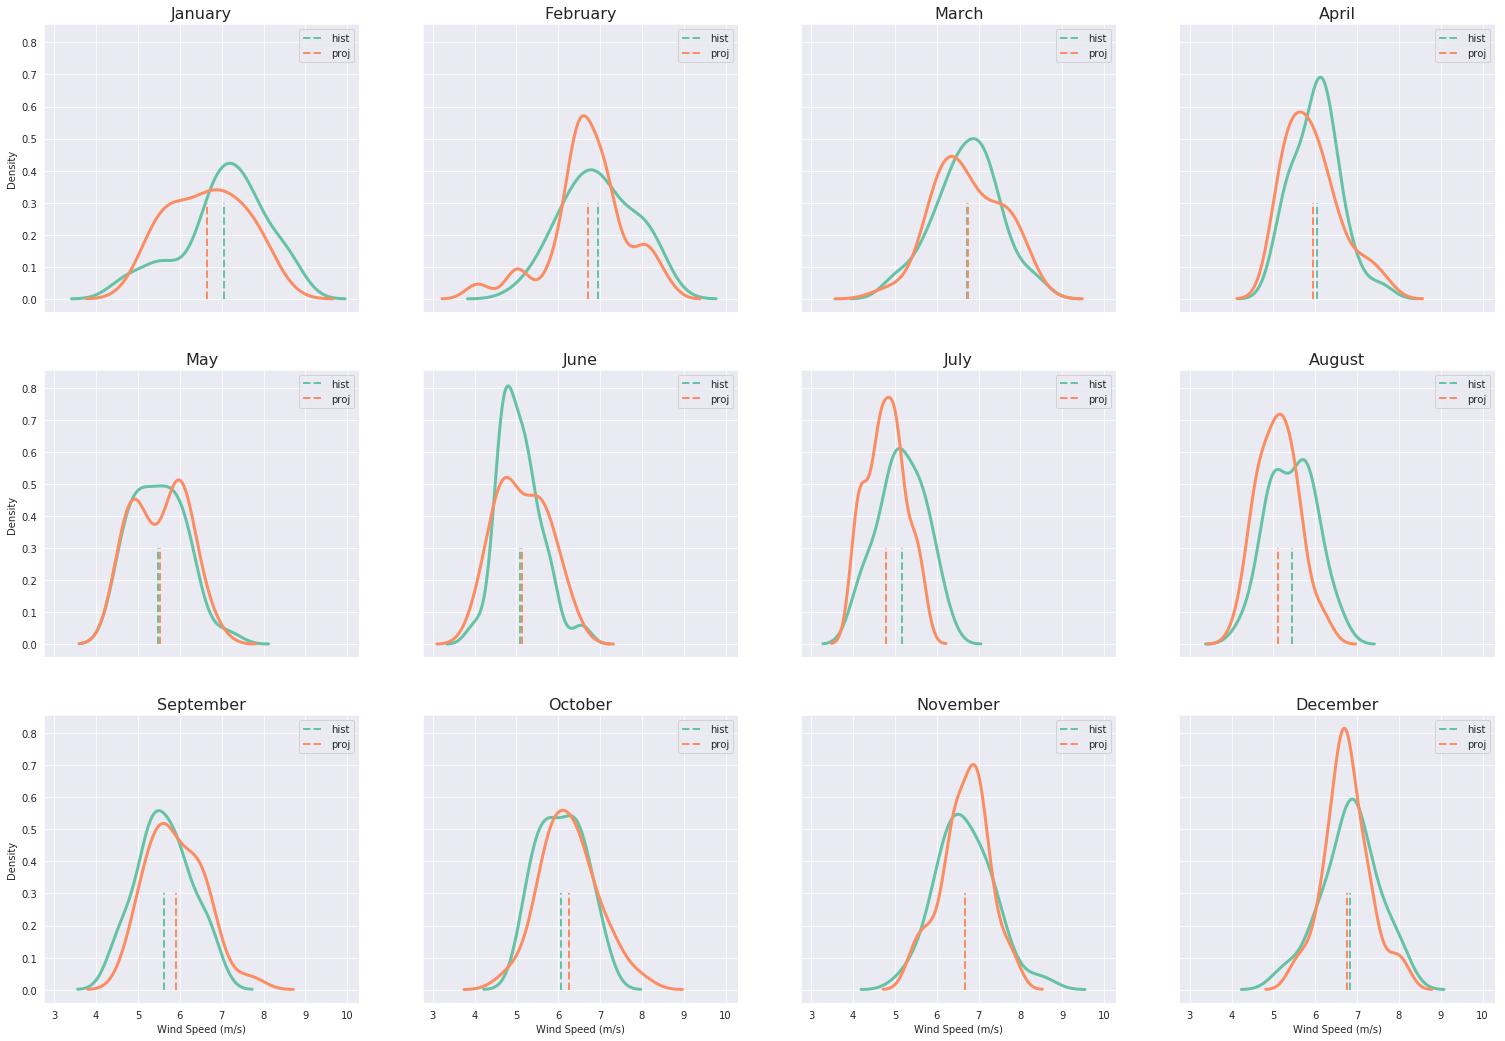

In [92]:
month_lab=[
    'January','February', 'March','April',
    'May','June','July','August',
    'September','October','November','December']

fig,chart = plt.subplots(
    nrows=3,
    ncols=4,
    figsize=(26, 18),
    sharex=True,
    sharey=True
)

sim_lab = Xr.columns[0]
for m in range(1,13):
    
    ix = [((x.year in list(range(1976,2006))) 
           & (x.month==m)) 
          for x in Xs.index]
    Xh = Xr.loc[ix,sim_lab].values
    ix = [((x.year in list(range(2021,2051))) 
           & (x.month==m)) 
          for x in Xs.index]
    Xf = Xr.loc[ix,sim_lab].values

    _ = sns.kdeplot(Xh,linewidth=3,color=cmap[0],
                    ax=chart[int((m-1)/4),(m-1)%4])
    _ = sns.kdeplot(Xf,linewidth=3,color=cmap[1],
                    ax=chart[int((m-1)/4),(m-1)%4])
    
    
    _ = chart[int((m-1)/4),(m-1)%4].set_title(month_lab[m-1],fontsize=16)

    _ = chart[int((m-1)/4),(m-1)%4].vlines(
        x=Xh.mean(),ymin=0,ymax=0.30,
        linestyles='dashed',
        color=cmap[0],
        linewidth=2,
        label='hist')
    _ = chart[int((m-1)/4),(m-1)%4].vlines(
        x=Xf.mean(),ymin=0,ymax=0.30,
        linestyles='dashed',
        color=cmap[1],
        linewidth=2,
        label='proj')
    _ = chart[int((m-1)/4),(m-1)%4].legend()
    if m in list(range(9,13)) : 
        _ = chart[int((m-1)/4),(m-1)%4].set_xlabel('Wind Speed (m/s)')
    if m in [1,5,9] : 
        _ = chart[int((m-1)/4),(m-1)%4].set_ylabel('Density')
    
    

Above have KDE plots for mean monthly wind speed values for a site within a historical and projected climatology period with the mean indicated with vertical dashed lines. (The simulation values have been bias corrected).
Which shows what changes between time periods within a single simulation, but hard to follow if add multiple simulations.

In [138]:
x = np.arange(0,10,0.2)
Kd = pd.DataFrame(
    index=x,
    columns=Xr.columns)
Mu = pd.DataFrame(
    index=Xr.columns,
    columns=['hist','proj'])

m = 7
for sim_lab in Xr.columns : 
    
    ix = [((x.year in list(range(1976,2006))) 
           & (x.month==m)) 
          for x in Xs.index]
    Xh = Xr.loc[ix,sim_lab].values
    estm = KernelDensity(
        kernel='gaussian',bandwidth=0.5
    ).fit(Xh.reshape(-1, 1))
    Kh = np.exp(estm.score_samples(x.reshape(-1,1)))
    Mu.loc[sim_lab,'hist'] = Xh.mean()

    ix = [((x.year in list(range(2021,2051))) 
           & (x.month==m)) 
          for x in Xs.index]
    Xf = Xr.loc[ix,sim_lab].values
    estm = KernelDensity(
        kernel='gaussian',bandwidth=0.5
    ).fit(Xf.reshape(-1, 1))
    Kf = np.exp(estm.score_samples(x.reshape(-1,1)))
    Mu.loc[sim_lab,'proj'] = Xf.mean()

    Kd.loc[:,sim_lab] = Kf-Kh
    

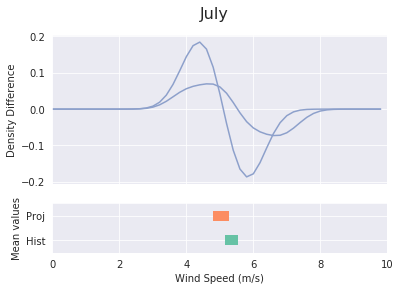

In [140]:
fig,chart = plt.subplots(2,gridspec_kw={'height_ratios': [3,1]},sharex=True)
    
_ = chart[0].set_title('')

_ = chart[0].plot(
    Kd,
    color=cmap[2])
_ = chart[0].set_xlim(0,10)
_ = chart[0].set_ylabel('Density Difference')

_ = chart[1].hlines(
    y=-0.5,
    xmin=Mu['hist'].min(),
    xmax=Mu['hist'].max(),
    color=cmap[0],
    linewidth=10)
_ = chart[1].hlines(
    y=0.5,
    xmin=Mu['proj'].min(),
    xmax=Mu['proj'].max(),
    color=cmap[1],
    linewidth=10)


_ = chart[1].set_xlim(0,10)
_ = chart[1].set_ylim(-1,1)
_ = chart[1].set_yticks([-0.5,0.5])
_ = chart[1].set_yticklabels(['Hist','Proj'])
_ = chart[1].set_ylabel('Mean values')
_ = chart[1].set_xlabel('Wind Speed (m/s)')

_ = plt.suptitle(month_lab[m-1],fontsize=16)

Above (using just two simulations) is idea for how to show the data of the above plot, but with ensemble values.
The top plane is the difference between the KDE estimate for the projection and the historical period, and then the bottom plane shows the range of mean values for the period from across the ensemble (so left end of a bar is the min mean value from the ensemble and the right end of a bar is the max mean value from the ensemble).
So can see that the climatology mean value is lower in the future period and can see that that's a result of in both ensembles the density of higher level wind speed values has decreased and increased on over the values closer to the 'new' mean.